In [5]:
import pandas as pd
import numpy as np

#treino = pd.read_csv('merged_treinofinal.csv')
treino = pd.read_csv('TH.csv')

In [6]:
treino['Data'] = pd.to_datetime(treino['Data']).dt.date

In [7]:
import datetime
#Horário de verão ou inverno
treino['Horario'] = 1

treino.loc[treino['Data'] < datetime.date(2023,3,26), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2022,10,30), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2022,3,27), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2021,10,31), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2021,3,28), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2020,10,25), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2020,3,29), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2019,10,27), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2019,3,31), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2018,10,28), 'Horario'] = 1

treino['hora_noite'] = pd.to_datetime(treino['hora_noite'])
treino.loc[treino['Horario'] == 1, 'hora_noite'] = treino.loc[treino['Horario'] == 1, 'hora_noite'] + pd.Timedelta(hours=1)
treino['hora_noite'] = treino['hora_noite'].dt.time

treino['Horário'] = pd.to_datetime(treino['Horário']).dt.time
treino['Noite'] = treino['Horário'] > treino['hora_noite']

In [8]:
treino['Noite'].value_counts()

False    923
True     301
Name: Noite, dtype: int64

In [9]:
treino['dif'] = treino['goals_home'] - treino['goals_away']
treino['xg_dif'] = treino['xG_home'] - treino['xG_away']

treino.loc[treino['dif']>0, 'result'] = 'H'
treino.loc[treino['dif']==0, 'result'] = 'D'
treino.loc[treino['dif']<0, 'result'] = 'A'

In [10]:
#Define o favorito
treino.loc[treino['B365H'] < 2.26, 'fav'] = 'H'
treino.loc[treino['B365H'] < 1.40, 'fav'] = 'HH'
treino.loc[treino['B365A'] < 2.26, 'fav'] = 'A'
treino.loc[treino['B365A'] < 1.40, 'fav'] = 'AA'
treino.loc[treino['fav'].isna(), 'fav'] = 'D'

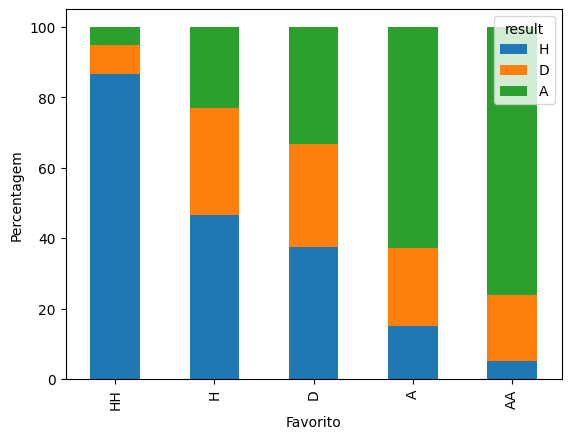

In [11]:
import matplotlib.pyplot as plt
order = ['H', 'D', 'A']
category_order = ['HH', 'H', 'D', 'A', 'AA']

# Convert 'x' column to categorical data type with the specified order
treino['fav'] = pd.Categorical(treino['fav'], categories=category_order, ordered=True)
treino['result'] = pd.Categorical(treino['result'], categories=order, ordered=True)

# Calculate the percentage of values in column 'y' for each unique value in column 'x'
result = treino.groupby('fav')['result'].value_counts(normalize=True) * 100

# Criar o gráfico de barras
result.unstack().plot(kind='bar',stacked=True)

# Configurar os rótulos dos eixos
plt.xlabel('Favorito')
plt.ylabel('Percentagem')

# Exibir o gráfico
plt.show()

<AxesSubplot: ylabel='fav'>

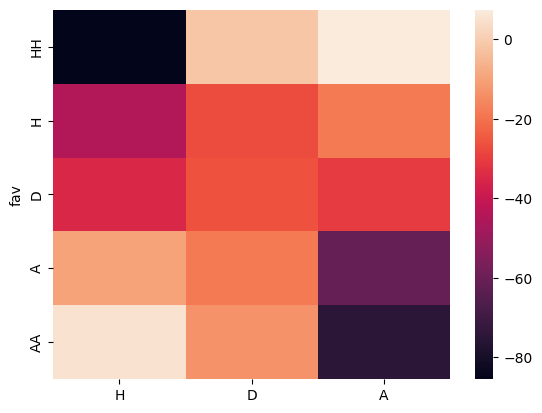

In [12]:
import seaborn as sns
#Fazer reverse ao cmap

order = ['H', 'D', 'A']

sns.heatmap(treino[['fav','B365H','B365D','B365A']].groupby('fav').mean().rename({'B365H': 'H','B365D': 'D', 'B365A': 'A'}, axis=1) - result.unstack()[order].reindex(['HH', 'H', 'D', 'A', 'AA']))

In [13]:
treino[['Horário','result']].groupby('Horário').count()

,result
Horário,
12:45:00,1
13:00:00,1
14:00:00,3
14:30:00,13
15:00:00,110
15:30:00,141
16:00:00,28
16:30:00,15
17:00:00,41


In [14]:
import requests

datas = treino['Data'].unique()

for data in datas:
    url = f'https://api.sunrise-sunset.org/json?lat=41.4500&lng=-8.3000&date={data}'
    response = requests.get(url)
    resposta = response.json()
    treino.loc[treino['Data'] == data, 'hora_noite'] = resposta['results']['astronomical_twilight_end']
    print(data)


2018-08-10
2018-08-11
2018-08-12
2018-08-13
2018-08-17
2018-08-18
2018-08-19
2018-08-20
2018-08-24
2018-08-25
2018-08-26
2018-08-27
2018-08-31
2018-09-01
2018-09-02
2018-09-21
2018-09-22
2018-09-23
2018-09-24
2018-09-27
2018-09-28
2018-09-29
2018-09-30
2018-10-01
2018-10-05
2018-10-06
2018-10-07
2018-10-26
2018-10-27
2018-10-28
2018-11-02
2018-11-03
2018-11-04
2018-11-05
2018-11-09
2018-11-10
2018-11-11
2018-11-30
2018-12-01
2018-12-02
2018-12-03
2018-12-07
2018-12-08
2018-12-09
2018-12-10
2018-12-14
2018-12-15
2018-12-16
2018-12-22
2018-12-23
2019-01-02
2019-01-03
2019-01-05
2019-01-06
2019-01-07
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-18
2019-01-19
2019-01-20
2019-01-28
2019-01-29
2019-01-30
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-15
2019-03-16

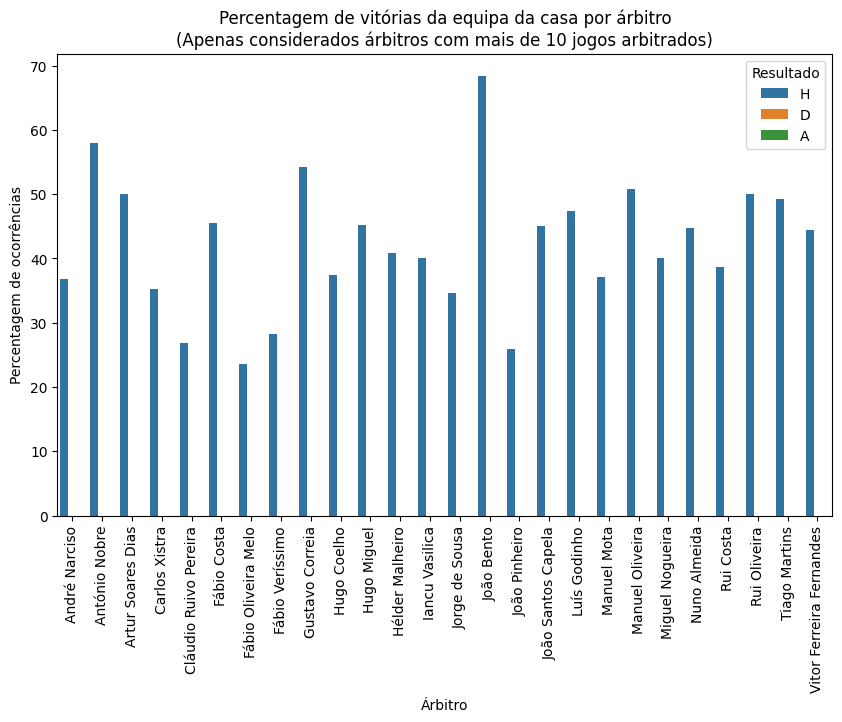

In [15]:
import matplotlib.pyplot as plt

# Calcular a contagem de ocorrências de cada valor por árbitro
# Contar o número de jogos arbitrados por árbitro
counts_arbitro = treino['Árbitro'].value_counts()

# Filtrar os árbitros com menos de 10 jogos arbitrados
arbitros_filtrados = counts_arbitro[counts_arbitro >= 10].index

# Filtrar o DataFrame original com base nos árbitros filtrados
df_filtrado = treino[treino['Árbitro'].isin(arbitros_filtrados)]

# Calcular a contagem de ocorrências de cada valor por árbitro no DataFrame filtrado
counts = df_filtrado.groupby('Árbitro')['result'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

counts = counts[counts['result'] == 'H']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Árbitro', y='Percentage', hue='result', data=counts)
plt.title('Percentagem de vitórias da equipa da casa por árbitro\n(Apenas considerados árbitros com mais de 10 jogos arbitrados)')
plt.xlabel('Árbitro')
plt.ylabel('Percentagem de ocorrências')
plt.xticks(rotation=90)
plt.legend(title='Resultado')

plt.show()

In [25]:
# Testar se há evidência estatística de que a presença do árbitro João Bento influencia a favor da equipa da casa

bento = treino[treino['Árbitro'] == 'João Bento']
nao_bento = treino[treino['Árbitro'] != 'João Bento']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(bento['dif'], nao_bento['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.93
# p-value: 0.0269

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

# Nota: Este árbitro foi despromovido na época 2020/21

t-test statistic: 1.93
p-value: 0.0269


In [24]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

bento = treino[treino['Árbitro'] == 'António Nobre']
nao_bento = treino[treino['Árbitro'] != 'António Nobre']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(bento['dif'], nao_bento['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.93
# p-value: 0.0269

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

# Nota: Este árbitro foi despromovido na época 2020/21

t-test statistic: 2.60
p-value: 0.0047


In [17]:
treino[treino['Árbitro'] == 'António Nobre']['dif'].mean()

0.86

In [18]:
treino[treino['Árbitro'] != 'António Nobre']['dif'].mean()

0.19591141396933562

<AxesSubplot: xlabel='Assistance'>

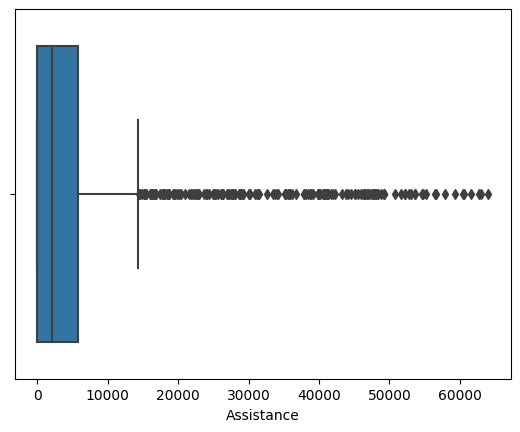

In [19]:
import seaborn as sns

sns.boxplot(x=treino['Assistance'])

In [20]:
treino['Assistance'].describe()

count     1224.000000
mean      6826.734477
std      12284.294068
min          0.000000
25%          0.000000
50%       2101.500000
75%       5704.250000
max      64064.000000
Name: Assistance, dtype: float64

In [21]:
treino['dif'] = treino['goals_home'] - treino['goals_away']
treino['xg_dif'] = treino['xG_home'] - treino['xG_away']

treino_t1 = treino[['Data','Assistance','dif','xg_dif']].copy()

covid = treino_t1[treino_t1['Assistance'] == 0]
nao_covid = treino_t1[treino_t1['Assistance'] != 0]

In [22]:
# -> H0: média da dif de golos com espectadores - média da dif de golos sem espectadores = 0
# -> H1: média da dif de golos com espectadores - média da dif de golos sem espectadores > 0
from scipy.stats import ttest_ind

test_statistic, p_value = ttest_ind(covid['dif'], nao_covid['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.72
# p-value: 0.7645

# Não rejeitamos a hipotese nula, a presença de espectadores não afeta a diferença de golos

t-test statistic: -0.72
p-value: 0.7645


In [23]:
# -> H0: média da dif de golos com espectadores - média da dif de golos sem espectadores = 0
# -> H1: média da dif de golos com espectadores - média da dif de golos sem espectadores > 0
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(covid['xg_dif'], nao_covid['xg_dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.67
# p-value: 0.7472

# Não rejeitamos a hipotese nula

t-test statistic: -0.67
p-value: 0.7472


In [28]:
treino.loc[treino['Dia'] == 'sáb', 'FDSem'] = 1
treino.loc[treino['Dia'] == 'dom', 'FDSem'] = 1
treino.loc[treino['FDSem'].isna(), 'FDSem'] = 0

In [38]:
treino['Noite'].value_counts()

False    923
True     301
Name: Noite, dtype: int64

In [39]:
fim = treino[treino['FDSem'] == 1]
nao_fim = treino[treino['FDSem'] != 1]

noite = treino[treino['Noite'] == True]
nao_noite = treino[treino['Noite'] == False]

In [40]:
# -> H0: média da dif de golos com jogo ao fim de semana
# -> H1: média da dif de golos com jogo durante a semana
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(fim['xg_dif'], nao_fim['xg_dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.46
# p-value: 0.0722

t-test statistic: 1.46
p-value: 0.0722


In [41]:
# -> H0: média da dif de golos com jogo à noite
# -> H1: média da dif de golos com jogo durante o dia
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(noite['xg_dif'], nao_noite['xg_dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.03
# p-value: 0.5101

t-test statistic: -0.03
p-value: 0.5101


In [42]:
treino['formacao_home'].value_counts()

4-2-3-1      264
4-3-3        233
4-4-2        225
3-4-3        123
4-1-4-1       71
5-4-1         27
3-4-1-2       14
4-4-1-1       13
5-3-2         13
3-5-2         11
4-5-1          6
4-1-2-1-2      6
4-1-3-2        5
4-2-2-2        3
4-3-1-2        3
3-2-4-1        1
4-3-2-1        1
3-5-1-1        1
Name: formacao_home, dtype: int64

In [54]:
treino['formacao_home'].isna().sum()

204

In [61]:
treino.columns

Index(['Jornada', 'Dia', 'Data', 'Horário', 'home', 'xG_home', 'xG_away',
       'away', 'Assistance', 'Local', 'Árbitro', 'Relatório da Partida',
       'goals_home', 'goals_away', 'formacao_home', 'formacao_away',
       'Faltas_home', 'Faltas_away', 'Escanteios_home', 'Escanteios_away',
       'Cruzamentos_home', 'Cruzamentos_away', 'Contatos_home',
       'Contatos_away', 'Bote defensivo_home', 'Bote defensivo_away',
       'Cortes_home', 'Cortes_away', 'Defesas_home', 'Defesas_away',
       'Impedimentos_home', 'Impedimentos_away', 'Tiro de meta_home',
       'Tiro de meta_away', 'Bolas longas_home', 'Bolas longas_away',
       'yellow_card_home', 'red_card_home', 'yellow_red_card_home',
       'yellow_card_away', 'red_card_away', 'yellow_red_card_away',
       'jogador1_home', 'jogador2_home', 'jogador3_home', 'jogador4_home',
       'jogador5_home', 'jogador6_home', 'jogador7_home', 'jogador8_home',
       'jogador9_home', 'jogador10_home', 'jogador11_home', 'jogador12_home',
  